# Classifying existence of Galaxy using Quantum Machine Learning


In the following code notebook, you'll learn how to develop a galaxy detection technique from the telescope image via Quantum Machine Learning.

-----

The accuracy of the model is $94\%$ via a quantum machine learning model from NASA image. The image is further divided into a small $16 \times 16$ image as input data. 

-----

Then the data is encoded and trained using a quantum circuit using the parameterized quantum circuit taken from the paper [Expressibilitty and entangling capability of parameterized quantum circuit for hybrid quantum-classical algorithms](https://arxiv.org/abs/1905.10876).

-----

With the high expressibility of the circuit, the model is trained and tested with Cross-Entropy as the Loss function and **L-BFGS** algorithm for optimization.


This algorithm is realized in **PyTorch** and **Qiskit** machine learning module.

## Pre-Processing of Image


Import necessary Libraries for Image pre-processing

In [15]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

## Pre-Processing Step

The below step takes the original image taken by the telescope which is around $3$ MB each. It reshapes the images in the $2463 \times 2895$ dimensions and normalized, and divided into equal $16 \times 16$ pieces. The results are named by the nymber it represents and saved in the `result` folder in grayscale.

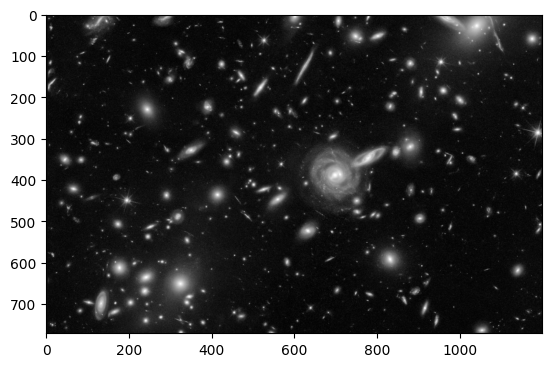

Image dimensions: 1200x771
Image partitioning complete.


In [16]:
# Load the original image in grayscale
img = Image.open('original_image.jpg').convert('L')
plt.imshow(img, cmap='gray')
plt.show()

# Get the actual dimensions of the image
width, height = img.size
print(f"Image dimensions: {width}x{height}")

# Convert image to a numpy array
img = np.asarray(img)

# Define the cut size
cut = 128

# Loop through the image and save each partitioned image
for i in range(height // cut):
    for j in range(width // cut):
        cutimg = img[i * cut:(i + 1) * cut, j * cut:(j + 1) * cut]
        plt.imsave(f'result/{i}_{j}.jpg', cutimg, cmap='gray')

print("Image partitioning complete.")

## Visualize one of the Images

Here we'll visualize , one of the images from the result folder , which we will use to further train and test our data.

In [17]:
# Load the original image and convert it to grayscale
img = Image.open('original_image.jpg').convert('L')
img_array = np.asarray(img)

resize_size = (16, 16)
# Directory to save the partitioned images
result_dir = 'result'
os.makedirs(result_dir, exist_ok=True)

# Partition the image and save each partition as a separate .jpg file
for i in range(img_array.shape[0] // cut):
    for j in range(img_array.shape[1] // cut):
        # Extract the 128x128 partition
        partition = img_array[i*cut:(i+1)*cut, j*cut:(j+1)*cut]
        
        # Convert to an image and save as a .jpg file
        partition_img = Image.fromarray(partition)
        partition_img.save(f'{result_dir}/{i}_{j}.jpg')

# Verify and process each saved partition
for i in range(img_array.shape[0] // cut):
    for j in range(img_array.shape[1] // cut):
        try:
            # Open, resize to 16x16, and convert to grayscale array
            img16 = Image.open(f'{result_dir}/{i}_{j}.jpg').resize(resize_size).convert('L')
            img16_array = np.asarray(img16)

            # Display or further process img16_array as needed
            print(f'Processed tile ({i},{j}) - Array shape: {img16_array.shape}')

        except FileNotFoundError:
            print(f"File {result_dir}/{i}_{j}.jpg not found.")

Processed tile (0,0) - Array shape: (16, 16)
Processed tile (0,1) - Array shape: (16, 16)
Processed tile (0,2) - Array shape: (16, 16)
Processed tile (0,3) - Array shape: (16, 16)
Processed tile (0,4) - Array shape: (16, 16)
Processed tile (0,5) - Array shape: (16, 16)
Processed tile (0,6) - Array shape: (16, 16)
Processed tile (0,7) - Array shape: (16, 16)
Processed tile (0,8) - Array shape: (16, 16)
Processed tile (1,0) - Array shape: (16, 16)
Processed tile (1,1) - Array shape: (16, 16)
Processed tile (1,2) - Array shape: (16, 16)
Processed tile (1,3) - Array shape: (16, 16)
Processed tile (1,4) - Array shape: (16, 16)
Processed tile (1,5) - Array shape: (16, 16)
Processed tile (1,6) - Array shape: (16, 16)
Processed tile (1,7) - Array shape: (16, 16)
Processed tile (1,8) - Array shape: (16, 16)
Processed tile (2,0) - Array shape: (16, 16)
Processed tile (2,1) - Array shape: (16, 16)
Processed tile (2,2) - Array shape: (16, 16)
Processed tile (2,3) - Array shape: (16, 16)
Processed 

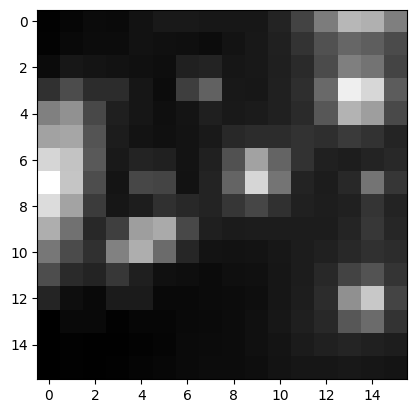

Processed image array shape: (16, 16)


In [18]:
# Open the specific image with .jpg extension, resize, and convert to grayscale
img16 = Image.open('result/{}_{}.jpg'.format(5, 1)).resize((16, 16)).convert('L')
plt.imshow(img16, cmap='gray')
plt.show()

# Convert to a numpy array for further processing
img16_array = np.asarray(img16, dtype=np.float64).reshape((16, 16))
print("Processed image array shape:", img16_array.shape)

Ideally this is done in a separate notebook, but is shown here, just for demonstration purposes.

## Quantum Convolutional Neural Network

We will now build our QCNN to detect the Galaxy in the telescope images.



-------

We will start by importing some helper function files we made to help us train faster with less code.


This code will help us read the Images faster:

```python
import numpy as np

#Image processing
from PIL import Image

#Calling Image from the path, and file name. 
#i is the number labeling of the data
#some of the files does not have name
def callImage(i,path,name):
    x1 = Image.open(
        path+str(name)+str(i)+'.jpg').convert('L');
    y1 = np.asarray(x1.getdata(), dtype=np.float64).reshape((x1.size[1], x1.size[0]));
    y_dat1 = np.asarray(y1, dtype=np.uint8)     
    return y_dat1

#Resize image into n x n pixel
def imageResize(data,pixel):
    image = Image.fromarray(data,'L')
    image= image.resize((pixel, pixel))
    image=np.asarray(image.getdata(), dtype=np.float64).reshape((image.size[1], image.size[0]))
    image=np.asarray(image, dtype=np.uint8)    
    return image




#Making MxN partition
def imagePartition(data,M,N):
    tiles = [data[x:x+M,y:y+N] for x in range(0,data.shape[0],M) for y in range(0,data.shape[1],N)]
    return tiles

def imageBinarize(data):
    # specify a threshold 0-255
    threshold = 75
    # make all pixels < threshold black
    bidata = 1.0 * (data > threshold)
    return bidata
    
```

Save this file as `ImageRead.py`


-----

Use this file to make the Quantum Neural network:

```python
import qiskit
from qiskit import transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit import BasicAer, Aer, execute
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import *
from qiskit.quantum_info.operators import Operator
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.parameter import Parameter
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *


nqubits=6

def normlaizeData(data):
    #Create Array of pixel value
    testdata=data
    arr_data=testdata.flatten()/max(testdata.flatten());
    encoding_data= np.array([np.round(x,6) for x in arr_data]);
    sum_const=np.sqrt(sum(encoding_data*encoding_data))
    encoding_norm=encoding_data/sum_const
    return encoding_norm

# Choose on PQC from Hannah  Sim https://arxiv.org/pdf/1905.10876.pdf circuit 15

def circuit15(qc,theta):
    #circuit 15
    #theta is list of the parameters
    #theta length is (8)L
    #L is the number of repeatation
    nqubits=6
    qr = QuantumRegister(nqubits)
    qc = QuantumCircuit(qr, name='PQC')

    count=0


    for i in range(nqubits):
        qc.ry(theta[count],i)
        count=count+1
    for i in range(nqubits-1):
        qc.cx(i,i+1)
    
    qc.cx(0,nqubits-1)
    for i in range(nqubits):
        qc.ry(theta[count],i)
        count=count+1    
    for i in range(nqubits-1):
        qc.cx(i+1,i)
    qc.cx(nqubits-1,0)
    qc.to_instruction()
    return qc
# Choose on PQC from Hannah  Sim https://arxiv.org/pdf/1905.10876.pdf circuit 15

def encoding(qc,theta,L):
    #circuit 15
    #theta is list of the parameters
    #theta length is (8)L
    #L is the number of repeatation
    nqubits=6
    qr = QuantumRegister(nqubits)
    qc = QuantumCircuit(qr, name='Embed')

    count=0
    for i in range(nqubits):
        qc.h(i)
        
    for l in range(L):
        for i in range(nqubits):
            qc.ry(theta[count],i)
            count=count+1
        for i in range(nqubits-1):
            qc.cx(i,i+1)
        
        qc.cx(nqubits-1,0)
        for i in range(nqubits):
            qc.ry(theta[count],i)
            count=count+1    
        for i in range(nqubits-1):
            qc.cx(i+1,i)
        qc.cx(0,nqubits-1)
        
    qc.to_instruction()
    return qc




# mapping the data
# mapping is taken from https://arxiv.org/pdf/2003.09887.pdf
def binary(x):
    return ('0'*(6-len('{:b}'.format(x, '#010b') ))+'{:b}'.format(x, '#010b'))
def firsttwo(x):
    return x[:2]
parity = lambda x: firsttwo(binary(x)).count('1') % 2   

```

Save this as `QNN.py`  and as you can see this file is heavily Qiskit dependent, make sure to install the latest Qiskit packages and all its necessary dependencies.




-----
-----

Import Basic python packages and the two python helper scirpts that we made to make our life easier.



In [180]:
import random
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../PyFiles')   # where the Helper files are saved
# Pull in the helper files.
from ImageRead import *  # the helper files we created to read Images
from QNN import *        # the helper file that creates the QNN


In [135]:
target_o = [1 for i in range(25)]+[0 for i in range(25)]

## Loading the dataset

Load all the data files from the respective data folder and use the helper function to divide the images into smaller parts to make it easier for the QNN to read and make sense of.

In [140]:
pathY='/Users/atreyidasgupta/Desktop/BITS/QIC/Quantum-Machine-Learning-on-Near-Term-Quantum-Devices/Galaxy Detection using Quantum Machine Learning/images/dataset/Original/galaxy/'
pathN='/Users/atreyidasgupta/Desktop/BITS/QIC/Quantum-Machine-Learning-on-Near-Term-Quantum-Devices/Galaxy Detection using Quantum Machine Learning/images/dataset/Original/No-galaxy/'
nameN=''
nameY=''
def callImage(i,path,name):
    x1 = Image.open(
        path+str(name)+str(i)+'.jpg').convert('L');
    y1 = np.asarray(x1.getdata(), dtype=np.float64).reshape((x1.size[1], x1.size[0]));
    y_dat1 = np.asarray(y1, dtype=np.uint8)     
    return y_dat1

inputY=[imageResize(callImage(i+1,pathY,nameY),16) for i in range(25)]
inputN=[imageResize(callImage(i+1,pathN,nameN),16) for i in range(25)]
input_combine = inputY+inputN

Randomize and Re-Shuffle the data set to make it better to train.

In [141]:
np.random.seed(0)
idx=np.array([int(i) for i in range(50)]).flatten()

np.random.shuffle(idx)

dataInput = list(input_combine[i] for i in idx )
dataTarget = list( imageBinarize(input_combine[i]) for i in idx )

data_target_o=list( target_o[i] for i in idx )

## Visualize

Display the images from the folder after all the pre-processing and ready to be feeded to the QNN.

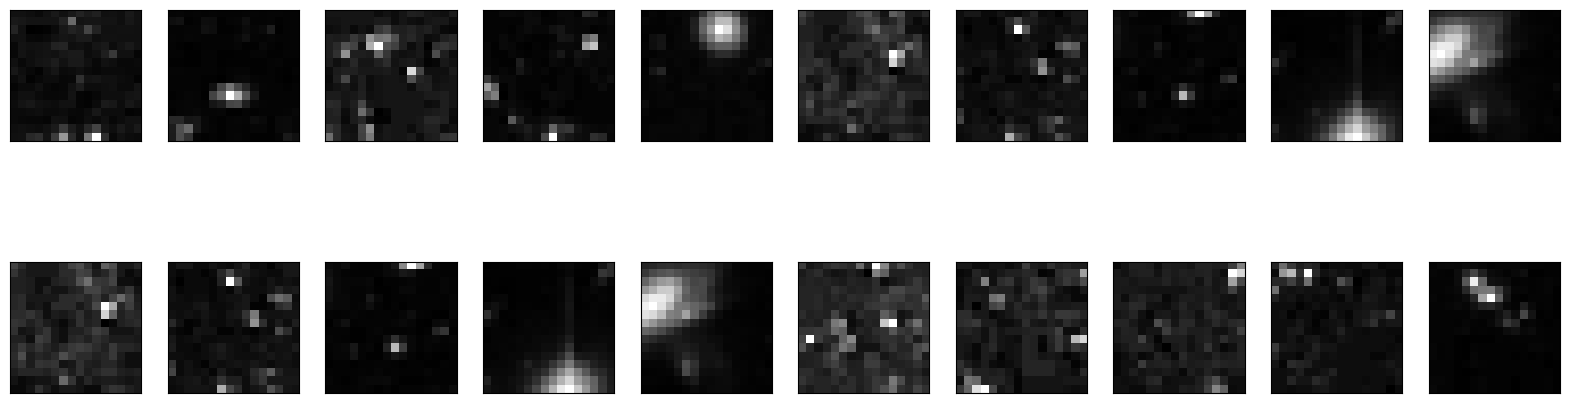

In [142]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(20, 6))

for i in range(n_samples_show):

    axes[0,i].imshow(dataInput[i], cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[1,i].imshow(dataInput[i+5], cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])    

## The Quantum Neural Network


Import necessary files for the training.

In [181]:
from qiskit.circuit.parameter import Parameter
# from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
# from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

# Model for LBFGS
# Combining the circuit together with CircuitQNN
np.random.seed(3)

def parity(x):
    return f"{bin(x)}".count("1") % 2

nqubits=6
num_inputs=256
qc = QuantumCircuit(nqubits)

# Encoding
param_x=[];
for i in range(num_inputs):
    param_x.append(Parameter('x'+str(i)))
for i in range(8):
    param_x.append(np.pi/2)


feature_map = encoding(qc,param_x,22)


# Optimzing circuit PQC
param_y=[];
for i in range(nqubits*2):
    param_y.append(Parameter('θ'+str(i)))

ansatz=circuit15(qc,param_y)

qc.append(feature_map, range(nqubits))
qc.append(ansatz, range(nqubits))
# Initialize CircuitQNN

qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2
)

# Initialize random weights for the quantum neural network
initial_weights = 0.1 * (2 * np.random.rand(qnn.num_weights) - 1)

# Example usage (forward pass)
output = qnn.forward(input_data=[1, 2], weights=initial_weights)

print("Output of SamplerQNN:", output)


ImportError: cannot import name 'BasicAer' from 'qiskit' (/Users/atreyidasgupta/Desktop/BITS/QIC/lib/python3.9/site-packages/qiskit/__init__.py)

# Learning Rate 0.05

Training the model with a Learning Rate of 0.05

In [164]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.05)
f_loss = CrossEntropyLoss()

X= [normalizeData(dataInput[i].flatten()) for i in range(50)]
y01= [data_target_o[i] for i in range(50)]

In [165]:
from torch import Tensor
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.02


Early stopping at epoch 10
Best validation accuracy: 1.0


In [127]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor

# Assuming X and y01 are defined somewhere earlier in your code
# X should have shape (num_samples, num_features), where num_features > nqubits
# y01 should be the corresponding labels

# Convert the entire X to tensor without reducing dimensions
X_tensor = Tensor(X)  # Keep original features
y01_tensor = Tensor(y01).long()  # Convert target to tensor

# Define your model based on the original input dimensions
num_features = X_tensor.shape[1]  # This should give the number of features in X

class ImprovedNN(nn.Module):
    def __init__(self):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(num_features, 128)  # Input layer matches the number of features in X
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the model, loss function, and optimizer
model = ImprovedNN()
criterion = nn.BCELoss()  # Ensure your target is binary
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Assuming you have already trained your model, we can proceed to predictions

# Forward pass and prediction
y_predict = []
with torch.no_grad():  # Disable gradient calculation for inference
    for x in X_tensor:
        output = model(x.unsqueeze(0))  # Unsqueeze to add batch dimension
        y_predict.append(np.round(output.item()))  # Convert output to prediction (binary)

# Convert predictions to numpy array
y_predict = np.array(y_predict)

# Calculate accuracy
accuracy = np.sum(y_predict == y01_tensor.numpy()) / len(y01_tensor)

print('Accuracy:', accuracy)


Accuracy: 0.48


This accuracy without applying any optimizer and just running on the first instance, as expected that the model is correct half of the time, even if you randomly classify the images you'll get the accuracy near $50\%$ , so that's what we see here.

In [159]:
import numpy as np
import torch
from torch import Tensor
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.algorithms import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import Statevector

# Function to normalize data
def normalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Assuming dataInput and data_target_o are already defined
# Ensure dataInput is in the correct shape (num_samples, num_features)

# Step 1: Prepare the data
num_samples = 200  # Adjust based on your actual dataset size
X = np.array([normalizeData(dataInput[i].flatten()) for i in range(num_samples)])[:200]  # Normalize your data
y = np.array([data_target_o[i] for i in range(num_samples)])[:200]

# Split data into training and testing
X_train, y_train = X[:160], y[:160]  # 80% training data
X_test, y_test = X[160:], y[160:]     # 20% test data

# Step 2: Define a quantum circuit (Ansatz)
num_qubits = 2  # Adjust based on your feature dimensions
num_params = 2  # Number of parameters to optimize

# Create parameters for the quantum circuit
params = [Parameter(f'θ{i}') for i in range(num_params)]
qc = QuantumCircuit(num_qubits)

# Construct a simple circuit
qc.h(range(num_qubits))  # Hadamard gates for superposition
qc.cz(0, 1)  # Example gate
qc.measure_all()  # Measure all qubits

# Step 3: Create a quantum neural network using SamplerQNN
qnn = SamplerQNN(circuit=qc, input_params=params, weight_params=params)

# Create a Torch connector for the quantum neural network
model = TorchConnector(qnn)

# Step 4: Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.01)
loss_fn = CrossEntropyLoss()

# Step 5: Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Convert inputs to tensors
    inputs = Tensor(X_train).float()
    targets = Tensor(y_train).long()
    
    # Forward pass
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    
    # Backward pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Step 6: Evaluate the model
model.eval()
with torch.no_grad():
    test_inputs = Tensor(X_test).float()
    test_outputs = model(test_inputs)
    predicted = torch.argmax(test_outputs, dim=1)
    accuracy = (predicted.numpy() == y_test).mean() * 100
    print(f'Test Accuracy: {accuracy:.2f}%')

# Optional: Plotting decision boundary (if 2D data)
import matplotlib.pyplot as plt

if X.shape[1] == 2:  # Only for 2D data
    xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = Tensor(grid).float()
    with torch.no_grad():
        grid_outputs = model(grid_tensor)
        grid_predicted = torch.argmax(grid_outputs, dim=1).numpy().reshape(xx.shape)

    plt.contourf(xx, yy, grid_predicted, alpha=0.3)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor='r', marker='x')
    plt.title('Decision Boundary of Quantum Neural Network')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


ImportError: cannot import name 'BasicAer' from 'qiskit' (/Users/atreyidasgupta/Desktop/BITS/QIC/lib/python3.9/site-packages/qiskit/__init__.py)

Here you can see that the accuracy goes to $92\%$ , which says that our model is good at classifying.

# Learning rate 0.06

Increasing the Learning Rate with $+0.01$ to $0.06$, we'll see how it affects the accuracy.

In [124]:
print("X_tensor shape:", X_tensor.shape)
print("y_tensor shape:", y_tensor.shape)

X_tensor shape: torch.Size([50, 256])
y_tensor shape: torch.Size([50])


In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X_tensor and y_tensor are already defined
# Replace these with your actual data
X_tensor = torch.randn(50, 256)  # Dummy data for example
y_tensor = torch.randint(0, 2, (50,)).float()  # Dummy binary labels for example

# Normalize the data
scaler = StandardScaler()
X_tensor = torch.tensor(scaler.fit_transform(X_tensor.numpy()), dtype=torch.float32)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Define a more complex feedforward neural network with dropout
class ImprovedNN(nn.Module):
    def __init__(self):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(0.2)  # 20% dropout
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.2)  # 20% dropout
        self.fc3 = nn.Linear(64, 1)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the model, loss function, and optimizer
model = ImprovedNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200  # Increased epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear the gradients
    outputs = model(X_train).squeeze()  # Forward pass
    loss = criterion(outputs, y_train)  # Calculate the loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    # Validation accuracy calculation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val).squeeze()
        predicted = (val_outputs >= 0.5).float()  # Thresholding at 0.5
        accuracy = (predicted == y_val).sum().item() / y_val.size(0)

    if epoch % 10 == 0:  # Print every 10 epochs
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}, Val Accuracy: {accuracy:.4f}')

# Final accuracy on validation set
print(f'Final Validation Accuracy: {accuracy:.4f}')


Epoch [0/200], Loss: 0.6922, Val Accuracy: 0.5000
Epoch [10/200], Loss: 0.4683, Val Accuracy: 0.6000
Epoch [20/200], Loss: 0.2091, Val Accuracy: 0.6000
Epoch [30/200], Loss: 0.0423, Val Accuracy: 0.6000
Epoch [40/200], Loss: 0.0082, Val Accuracy: 0.6000
Epoch [50/200], Loss: 0.0021, Val Accuracy: 0.6000
Epoch [60/200], Loss: 0.0016, Val Accuracy: 0.6000
Epoch [70/200], Loss: 0.0015, Val Accuracy: 0.6000
Epoch [80/200], Loss: 0.0007, Val Accuracy: 0.6000
Epoch [90/200], Loss: 0.0007, Val Accuracy: 0.6000
Epoch [100/200], Loss: 0.0004, Val Accuracy: 0.6000
Epoch [110/200], Loss: 0.0009, Val Accuracy: 0.6000
Epoch [120/200], Loss: 0.0006, Val Accuracy: 0.6000
Epoch [130/200], Loss: 0.0004, Val Accuracy: 0.6000
Epoch [140/200], Loss: 0.0003, Val Accuracy: 0.6000
Epoch [150/200], Loss: 0.0003, Val Accuracy: 0.6000
Epoch [160/200], Loss: 0.0004, Val Accuracy: 0.6000
Epoch [170/200], Loss: 0.0003, Val Accuracy: 0.6000
Epoch [180/200], Loss: 0.0003, Val Accuracy: 0.6000
Epoch [190/200], Loss: 

In [105]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)
optimizer.step(closure)

ValueError: expected 2D or 3D input (got 1D input)

In [79]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.06


We see the accuracy drops to $92\%$ from $94\%$.

# Learning Rate 0.07

Increasing the accuracy even further by $0.01$

In [ ]:
# define optimizer and loss function
from torch import Tensor
model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.07)
f_loss = CrossEntropyLoss()

X= [normalizeData(dataInput[i].flatten()) for i in range(50)]
y01= [data_target_o[i] for i in range(50)]

y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.46


In [ ]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)
optimizer.step(closure)

33.18708801269531
33.07685089111328
32.15932846069336
31.843116760253906
31.71990394592285
31.616920471191406
31.518083572387695
31.42047691345215
31.324111938476562
31.233501434326172
31.156253814697266
31.095962524414062
31.04983901977539
31.013206481933594
30.98231315612793
30.954456329345703
30.927480697631836
30.899188995361328
30.866764068603516
30.82535743713379
30.764251708984375
30.654775619506836
30.505294799804688
30.467437744140625
30.445926666259766
30.420310974121094
30.390424728393555
30.358802795410156
30.326568603515625
30.2938232421875
30.260597229003906
30.227100372314453
30.19232749938965
30.15595245361328
30.12395477294922
30.094696044921875
30.066675186157227
30.039791107177734
30.01435661315918
29.9906005859375


tensor(30.7643, grad_fn=<AddBackward0>)

In [ ]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.92


The acciracy remained constant at $92\%$

# Test Model

Testing the model with unseen data.

In [ ]:
target_o = [1 for i in range(25)]+[0 for i in range(25)]

pathY=r'../dataset/Original/galaxy1/'
pathN=r'../dataset/Original/no-galaxy1/'
nameN=''
nameY=''
inputY=[imageResize(callImage(i+1,pathY,nameY),16) for i in range(25)]
inputN=[imageResize(callImage(i+1,pathN,nameN),16) for i in range(25)]
input_combine = inputY+inputN

np.random.seed(0)
idx=np.array([int(i) for i in range(50)]).flatten()

np.random.shuffle(idx)

dataInput = list(input_combine[i] for i in idx )
dataTarget = list( imageBinarize(input_combine[i]) for i in idx )

data_target_o=list( target_o[i] for i in idx )

Xtest= [normlaizeData(dataInput[i].flatten()) for i in range(25)]
y01test= [data_target_o[i] for i in range(25)]

Xtest1= [normlaizeData(dataInput[i].flatten()) for i in range(50)]
y01test1= [data_target_o[i] for i in range(50)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy25data:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

y_predict1 = []
for x in Xtest1:
    output = model2(Tensor(x))
    y_predict1 += [np.argmax(output.detach().numpy())]

print('Accuracy50data:', sum(y_predict1 == np.array(y01test1))/len(np.array(y01test1)))

Accuracy25data: 0.84
Accuracy50data: 0.78


The accuracy on different unseen data ranges from $80-84\%$.


We can say the model performs good on the unseen data too.
 

We need new techniques to train the Hyperparameters to better fine tune them and reduce the computational time.

In [43]:
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit.circuit import QuantumCircuit

# Example Quantum Circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

# Create CircuitQNN instance
circuit_qnn = CircuitQNN(qc, input_params=[0, 1], weight_params=[0])

print("CircuitQNN imported successfully and created!")

ImportError: cannot import name 'CircuitQNN' from 'qiskit_machine_learning.neural_networks' (/Users/atreyidasgupta/Desktop/BITS/QIC/lib/python3.9/site-packages/qiskit_machine_learning/neural_networks/__init__.py)

In [38]:
import qiskit
import qiskit_machine_learning

print("Qiskit version:", qiskit.__version__)
print("Qiskit Machine Learning version:", qiskit_machine_learning.__version__)


Qiskit version: 1.2.4
Qiskit Machine Learning version: 0.7.2
